In [6]:
lines = r"""1 45571U 20025AS  23365.96197248  .00503980  13035-3  71339-3 0  8283\
2 45571  53.0305 356.1487 0008442  93.8422 357.0633 16.05036521205441
1 58664U 23208E   23365.96274149  .03637511  24924-5  62501-3 0    85\
2 58664  97.3803 118.4678 0190328  22.9094 113.3380 15.98433958   740
1 25544U 98067A   24001.01267188  .00016541  00000-0  29758-3 0  5694\
2 25544  51.6422  68.6294 0003347 343.4617  78.0593 15.49961425432470"""

lines = lines.split("\n")
print(lines)

['1 45571U 20025AS  23365.96197248  .00503980  13035-3  71339-3 0  8283\\', '2 45571  53.0305 356.1487 0008442  93.8422 357.0633 16.05036521205441', '1 58664U 23208E   23365.96274149  .03637511  24924-5  62501-3 0    85\\', '2 58664  97.3803 118.4678 0190328  22.9094 113.3380 15.98433958   740', '1 25544U 98067A   24001.01267188  .00016541  00000-0  29758-3 0  5694\\', '2 25544  51.6422  68.6294 0003347 343.4617  78.0593 15.49961425432470']


In [ ]:
import torch
import matplotlib.pyplot as plt
from customTLE import CustomTLE
import customMLDSGP4

device = torch.device("cuda")
print(f"Current Device: {device}")
#we load a pre-trained ML-dSGP4 model:
ml_dsgp4 = customMLDSGP4.mldsgp4(hidden_size=35)



Current Device: cuda


In [8]:
tle_list = []
i = 0
record = []
while i < len(lines) -1:
    record.append([lines[i], lines[i+1]])
    i+=2

for instance in record:
    tle = CustomTLE(instance)
    tle_list.append(tle)
    
print(len(tle_list))

3


In [9]:

print("Finished reading into TLE objects")
print("Starting simulation")

tles_expanded = []
for tle in tle_list:
    tles_expanded += [tle]*10000

tsinces = torch.cat([torch.linspace(0,48*60,10000)]*len(tle_list))

#first let's initialize them:
with torch.no_grad():    
    states_normalized_out = ml_dsgp4(tles_expanded, tsinces)

states_normalized_out=states_normalized_out.detach().clone().numpy()

print(f"Propagating {len(tle_list)} TLEs")

# Instead of using the original tle_list (with 3 entries),
# use tles_ which has each TLE repeated 10000 times (total 30000 entries)
_, batched_tle = customMLDSGP4.initialize_tle(tles_expanded)
states_teme = customMLDSGP4.propagate_batch(batched_tle, tsinces)


print("Finished propagation")

Finished reading into TLE objects
Starting simulation
Propagating 3 TLEs
Finished propagation


In [ ]:
print(tles_expanded[0]["_epoch"])

2023-12-31 23:05:14.422271


(np.float64(-10024.623807537253),
 np.float64(9629.959837417817),
 np.float64(-10056.30275057334),
 np.float64(9598.280894381729),
 np.float64(-7515.10466651501),
 np.float64(7225.833067201294))

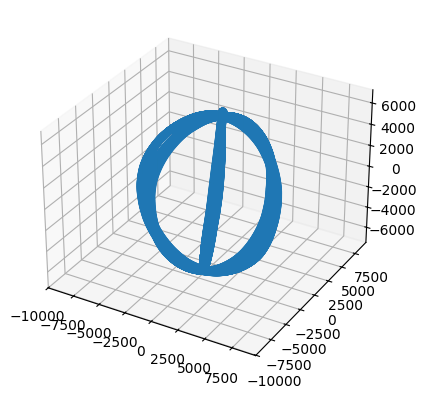

In [10]:

#if we want to unnormalize:
position=states_normalized_out[:,:3]*ml_dsgp4.normalization_R
velocity=states_normalized_out[:,3:]*ml_dsgp4.normalization_V
#let's plot it:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(position[:,0], position[:,1], position[:,2])
ax.axis('equal')